In [ ]:
!pip3 install opencv-contrib-python

# Part 02: Image Retrieval

_You are suggested to work on this part after Lecture 06 (Multimedia Information Retrieval - Image Retrieval)_

In the second part of the assignment, you will work on a simple image retrieval problem, and implement parts of the Bag Of Words retrieval approach. You will work with images from the Mapillary Street-Level Sequences  (MSLS) data set. For an autonomous car, for instance, it is important to retrieve from a map or reference set of images the most similar images to what is being recording with a camera, in order to recognize a previously visited place.

You are asked to retrieve, from a collection of city images (we work with images from London), the most similar images to given queries. For this, we provide you a dataset, composed of:

* _database/_ folder: contains XXX images used as map (document collection)
* _query/_ folder: contains XXX images used as queries
* _database/database_lite.json_: list of images included in the map (the order is important because it correspond to the orded in the similarity matrix - see below)
* _query/query_lite.json_: list of images used for query (the order is important because it correspond to the orded in the similarity matrix - see below)
* _london_lite_gt.h5_: matrix of image similarity, containts all the information about relevant/non-relevant images 

__Relevance judgements (in the form of a matrix, the structure of which is explained below)__
For each query image, we provide a specification of which map images are relevant (1 in the london_lite_gt.h5 file) and which are not (0 in the london_lite_gt.h5). The content of the '.h5' file is a matrix, with rows corresponding to query images and columns corresponding to the map images. The matrix has thus has $N=500$ rows (where $N$ is the number of query images in the folder `query/images/`) and $M=1000$ columns (where $M$ is the number of query images in the folder `database/images/`). 

The $i$-th row of the matrix thus contains the relevance judgement for the $i$-th query image with respect to the map images. For instance, row 5 of the matrix is a vector of 1000 elements (one for each image in the map), in which each element is 1 if the corresponding map image is relevant for the query image 5, or $0$ in case it is not relevant.

Please note that in Python the index of a vector (or matrix) starts from 0 (instead of 1). This means that the first element of a vector has index $0$, and that, for example, the element with index $25$ corresponds to the 26-th element of the vector. 
Thus, as an example, the cell $(10, 25)$ contains the relevance of the 26-th map image for the $11$-th query image (i.e. is the 26-th image in the map relevan (1) or not (0) for the query image number 11?).
 

In the following, we provide you the code for loading the data set and to visualize the images.


> Note: for this assignment we use the '\_lite' version of the map and query set, which include a reduced number of images. This is to simplify the computations required to work on this assignment. For the final project, you can work using the full-sized sets of images from London. This will require longer computations, but you can obtain more reliable results.

## Load the query and map images
In the following we load the list of images in the map set (collection) and in the query set.
For each image, we have information also about the absolute coordinates of the camera that took the picture in the city of London. _Do not consider these coordinates for the exercises. We use them only to show the trajectory followed by the camera taking the pictures (see below)._ 

In [1]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tqdm

# map
with open("data02/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])


### Visualization of image locations
The pictures in the map (collection) and query sets have been recorded in different parts of the city of London. The map images are indicated by the blue trajectory (run the code below), while the query images are indicated by the orange trajectory segments.

You can notice how the blue and orange trajectories overlap partially. In that overlapping area, the query images will have some relevant images among the map images. Conversely, in the areas there there is no overlap (and the points are not even close), the map images will be non-relevant for the query images. 
Please read more details in the next sections, where the ground truth relevance judgements are provided and explained.

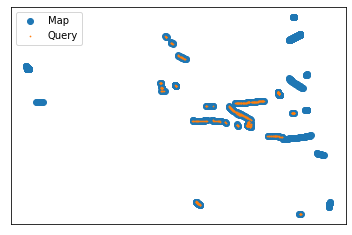

In [2]:
plt.scatter(m_loc[:,0],m_loc[:,1], label="Map")
plt.scatter(q_loc[:,0],q_loc[:,1], label="Query", s=0.5)
#plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

## Load the similarity matrix (relevance judgements)

The london_lite_gt.h5 file contains two sets of relevance  judgements, specified by the keys `sim` and `fov`.
`sim` specifies it in the form 0/1 (non-relevant/relevant).
`fov` (that stands for field of view) specifies it as a degree of similarity, a value defined in the interval $[0, 1]$ that indicates how much the query and map images are similar. We do not use it for this assignment, but you may consider it when working on the final project.


In [3]:
# loading the relevance judgements
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

We use the matrix with binary relevance judgements `sim` in this assignment. 
To obtain the relevance judgement of the map image 'map_id' for the query 'query_id', you  can use the syntax `sim[query_id, map_id]`. 

In the following we show few examples:

In [4]:
# note that for the 10th map image we have to access column 10-1=9
print('Relevance of the 10th map image for the 5th query image: ', sim[4, 9])
# similarly for the 221th query image we access column 221-1=220
print('Relevance of the 221th map image for the 151th query image: ', sim[150, 220])

Relevance of the 10th map image for the 5th query image:  0
Relevance of the 221th map image for the 151th query image:  1


### Distribution of relevant images per query

The majority of query images have between $0$ and $10$ relevant map images (ground truth positive matches). A few query images have no relevant map images (no positive matches) in the database. A few others have up to $30$ positive database images.

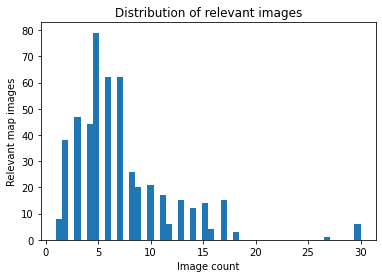

In [5]:
plt.hist(np.sum(sim, axis=1),bins=50)
plt.xlabel('Image count')
plt.ylabel('Relevant map images')
plt.title('Distribution of relevant images')
plt.show()

### Visualization of random images. 
For a given query image, we select one relevant and one non-relevant image from the map.
> By running several time the following cell, you can see how some of the relevant images are very difficult cases. This can give an idea of how complicate is to perform robust image retrieval.
This is also an indication that the retrieval results that you will compute will not be high (do not worry about them, then - focus on the methodology and discussions).

See below:

(-0.5, 340.5, 255.5, -0.5)

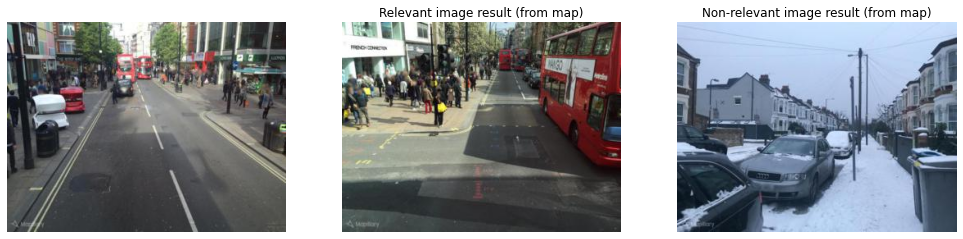

In [6]:
# generate random index for the query image
# You can try with it (but in the case a query image does not have relevant results in the map, the code will give an error)
query_idx = np.random.randint(0, 499) 

# For visualization purposes, we select a query image for which there are relevant and non-relevant results in the collection (map)
# query_idx = 120

# select the relevant and non-relevant map images for the randomly selected query image
rel = np.where(sim[query_idx, :] == 1)
nonrel = np.where(sim[query_idx, :] == 0)


# randomly select a relevant and non-relevant image
rel_idx = rel[0][np.random.randint(0, len(rel[0]) - 1)]
nonrel_idx = nonrel[0][np.random.randint(0, len(nonrel[0]) - 1)]

plt.figure(figsize=(17,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread('data02/' + q_imgs[query_idx]))
plt.axis("off")

plt.subplot(1,3,2)
plt.title('Relevant image result (from map)')
plt.imshow(plt.imread('data02/' + m_imgs[rel_idx]))
plt.axis("off")

plt.subplot(1,3,3)
plt.title('Non-relevant image result (from map)')
plt.imshow(plt.imread('data02/' + m_imgs[nonrel_idx]))
plt.axis("off")



If you want to collect all relevance judgement for the $i$-th query image, you need to access the (i-1)-th row of the matrix `sim`. To visualize the relevance judgment you have to loop over the accesses vector (a row of a matrix is a vector.

In the following an example of how to do that.

In [7]:
# accessing (and printing out) the relevance judgement for the query image number 16

query_id = 15  # 16-1
for idx in range(len(sim[query_id, :])):
    # idx is the index of the vector. It corresponds to the map image index
    # rel contains the relevance (0/1) of the idx-th map image for the considered query image (9th image in our case)
    print("Relevance of the %d-th map image for the 16-th query image: %d" % (idx, sim[query_id, idx]))

Relevance of the 0-th map image for the 16-th query image: 0
Relevance of the 1-th map image for the 16-th query image: 0
Relevance of the 2-th map image for the 16-th query image: 0
Relevance of the 3-th map image for the 16-th query image: 0
Relevance of the 4-th map image for the 16-th query image: 0
Relevance of the 5-th map image for the 16-th query image: 0
Relevance of the 6-th map image for the 16-th query image: 1
Relevance of the 7-th map image for the 16-th query image: 1
Relevance of the 8-th map image for the 16-th query image: 1
Relevance of the 9-th map image for the 16-th query image: 1
Relevance of the 10-th map image for the 16-th query image: 1
Relevance of the 11-th map image for the 16-th query image: 1
Relevance of the 12-th map image for the 16-th query image: 1
Relevance of the 13-th map image for the 16-th query image: 1
Relevance of the 14-th map image for the 16-th query image: 1
Relevance of the 15-th map image for the 16-th query image: 1
Relevance of the 1

# ASSIGNMENT: Bag of Words representation
As seen in the lecture, in order to construct a dictionary of 'visual' terms (words) from a collection of images, one can extract local features from the images (e.g. keypoints) and use a clustering algorithm to automatically find groups (i.e. clusters) of similar local features. The centroid of a cluster is also a feature vector and can be considered as a term to be used for the search and retrieval of similar images.

In this assignment, we use the [$K$-Means clustering algorithm](https://www.youtube.com/watch?v=_aWzGGNrcic) (where $k$ is defined as a parameter by us) to extract the visual dictionary of terms from the images in the map collection (in the cells below you will find more information).

In the following code (please study it), we:
* load the list of images in the map collection
* for each image we extract a maximum of 50 ORB keypoints (local keypoint features). Each keypoint is described by a vector of 256 elements (keypoint descriptor) that describes the local characteristics of the image.
* use the set of keypoint descriptors (50 keypoints * 1000 images = 50000 vectors) as input of the k-Means clustering algorithm
* compute k=32 cluster centroids (which correspond to the 32 terms of our dictionary) - k is a configurable parameter

> __Note:__ Please, find more information about ORB in the [ORB paper](https://ieeexplore.ieee.org/document/6126544) and in the [Scikit Image ORB documentation](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html).

> __Note 2:__ it may take some time to extract the descriptors from all images. Once extracted you can save them, and reload them when needed. If you change the number of centroids k, then you need to recompute the cluster centers.

In [22]:
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray

# Initialize the ORB descriptor
descriptor_extractor = ORB(n_keypoints=50)
# Initialize the data structure that will contain all the descriptors
descriptors = None

# Loop over map images
for img_name in m_imgs:
    #img = Image.open(os.path.join('data_image_retrieval/', img_name)).convert()
    #img = np.asarray(img)
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)  
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # Accumulate the computed descriptors
    if descriptors is None:
        descriptors = descriptors_img
    else:
        descriptors = np.vstack( (descriptors, descriptors_img))
    #print(descriptors.shape)
    
# We have extracted 50 descriptors per image, for 1000 images. The ORB descriptors have length 256
print(descriptors.shape)

(50000, 256)


### SURF feature extraction

In [23]:
import cv2 as cv


descriptor_extractor = cv.SIFT_create(50)
descriptors = None

for img_name in m_imgs:
    img = cv.imread(os.path.join('data02/', img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    _, descriptors_img = descriptor_extractor.detectAndCompute(img, None)
    
    if descriptors is None:
        descriptors = descriptors_img    
    else:
        descriptors = np.vstack((descriptors, descriptors_img))

print(descriptors.shape)
            
 

# Read the image
#img = cv.imread('chessboard.jpg')
 
# Convert to grayscale
#gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 
# Find the features (i.e. keypoints) and feature descriptors in the image
#sift = cv.SIFT_create()
#kp, des = sift.detectAndCompute(gray,None)
 
# Draw circles to indicate the location of features and the feature's orientation
#img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 

(50244, 128)


Save or load descriptors (comment/uncomment the code accordingly)

In [ ]:
import pickle
# save descriptors (uncomment if you want to save the computed descriptors)
#f = open('data02/ORB-descriptors-map.bin', 'wb')
#data = pickle.dump(descriptors, f)
#f.close()

# load pre-computed descriptors
f = open('data02/ORB-descriptors-map.bin', 'rb')
descriptors = pickle.load(f)
f.close()


## Clustering
Following the Bag of Words framework (see the slides of the lecture), we can define the basic 'words' that compose the images via a clustering algorithm that takes the descriptors of the map images (training) as input. The basic 'words' form a so called visual vocabulary and are learned by grouping together those descriptor vectors that are most similar, i.e. their distance is lower than that between other descriptors.

We do it by using the $K$-Means algorithm: find [here](https://en.wikipedia.org/wiki/K-means_clustering) some more information about KMeans and [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) the reference documentation of the algorithm in Scikit-learn. Also an explanatory video with examples [here](https://www.youtube.com/watch?v=_aWzGGNrcic).

> Note: running the clustering may take few minutes. Once computed, you can save the centroids and subsequently load tham before use. If you change the value of K, you need to recompute the clusters.


In [ ]:
import sklearn
from sklearn.cluster import KMeans

# clustering
K = 32  # number of clusters (equivalent to the number of words) we want to estimate
num_initialization = 5 # Number of time the k-means algorithm will be run with different centroid seeds.

# Run the k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=1)
clusters = kmeans.fit(descriptors)  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_

print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")
# Rememeber: the centroids can be considered as the words that compose our documents 
# -> in this case the basic components of the images


## Exercise 02.A: _'Bag of words' vector computation_

In order to compute the BoW representation of an image, we have to count the occurrences of the visual 'words', i.e. the local features, that we have learned in our visual vocabulary (using the $K$-Means clustering).

Given an image, we do the following:
   * we extract the local descriptors (we are using ORB descriptors in this assignment) 
   * for each descriptor we find the closest 'word' (i.e. the closes cluster centroid) in the visual vocabulary
   * we sum +1 to the counting of the occurence of the 'word' (in this way we construct the histogram of the occurrence of the visual 'words')
    
An image is thus described with a vector (of $K$ elements) that is an histogram of the occurrence of the words in the learned visual vocabulary (similar to the occurrence of words in a text document).  

In the following, implement the core of the function that computes the BoW vector. The function takes as input the centroids of the learned clusters (i.e. the vocabulary of the visual words) and the set of descriptors extracted from an image. It must return the BoW vector.

In [ ]:
from tqdm import tqdm
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray

# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    
    for i in range(n_descriptors):
        ## BEGIN ANSWER
        pred = kmeans.predict(img_descriptors[i].reshape(1, -1))
        bow_vector[pred[0]] += 1
        ## END ANSWER
    return bow_vector


descriptor_extractor = ORB(n_keypoints=50)

# Test the implementation of the BoW vector computation
img = plt.imread(os.path.join('data02/', q_imgs[0]))
img = rgb2gray(img)

descriptor_extractor.detect_and_extract(img)  
# keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
query_img_descriptors = descriptor_extractor.descriptors 

bow = bag_of_words(centroids, query_img_descriptors)
print("Size of the bow vector: ", bow.shape)
print("Bow vector: ", bow)


### Bag of words representation of the map images 
Given a query image, our aim is to find similar images in our collection (i.e. map) images.
To do that, we have to convert the query image into its Bag of words (BoW) representation and look for similar vectors in the collection (i.e. map) images.

At this stage, since we will do many queries, it is handy to compute the BoW vectors for all images in the collection (i.e. map) and reuse them for multiple queries. (We convert all images in the collection to their BoW representation).

> It is advised to study and understand the code below (it may take some time to run).

In [ ]:
bow_map_images = None
# loop over the images in the map set
for img_name in tqdm(m_imgs):
    # load image
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # extract the keypoints and corresponding descriptors (50 ORB descriptors)
    descriptor_extractor.detect_and_extract(img)
    img_descriptors = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

At this point, the 1000 images in the map have been converted into their BoW representation. The data structure has size $NxK$, where $N=1000$ is the number of map images, while $K=32$ is the number of basic 'words' of the BoW representation.



In [ ]:
print(bow_map_images.shape)

### Z-score normalization
In machine learning and data analysis problems, it is important to [normalize](https://en.wikipedia.org/wiki/Feature_scaling) (scale) the data, in order to avoid that features with larger range dominate the computation of distances (so skewing the computations). Here we use the Z-score normalization, meaning that we subtract the mean and divide by the variance (computed on the map images) of each feature (i.e. for each dimension of the BoW vectors). We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) library of Scikit.

> __Note__: when computing the query BoW vectors, then, we need to also normalize them (using the mean and variance of the map vectors).

In [ ]:
from sklearn import preprocessing
orig_bow_map_images = bow_map_images

# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)


## Exercise 02B: _Retrieve images_
We are ready to retrieve images from the collection (i.e. map) images, given the BoW representation of a query image. In order to do that, compute the Euclidean distance between the BoW vector of the query image and the BoW vector of all the collection images and return those with the smaller distance. 

_Hint:_ after computing the distances between the query image BoW vector and all BoW vectors of the map image, you may want to sort them in ascending order; the Numpy function [argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) may turn out to be useful.

> For this exercise you are asked to compute the Euclidean distance, but other distance metrics can also be used, e.g. Cosine distance, Minkowski Distance, Manhattan distance, etc. (this is left to you, if you want to explore them as well)

In [ ]:
from scipy.spatial.distance import euclidean, cityblock, hamming, cosine
from scipy.spatial import minkowski_distance
# receives as input the:
#   - bag of words vectors of the map images
#   - the bag of work vector of the query image
def retrieve_images(map_bow_vectors, query_bow, distance_func):
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None
    
    ## BEGIN ANSWER
    for i in range(n_map_bow_vectors):
        bow_distances[i] = distance_func(map_bow_vectors[i], query_bow)
    most_similar = np.argsort(bow_distances)
    ## END ANSWER
    
    return most_similar

# Retrieve the most similar images to query image 221 (index 221-1=220)
query_idx = 220
img = plt.imread("data02/" + q_imgs[query_idx])
img = rgb2gray(img)
# compute bag of words
descriptor_extractor.detect_and_extract(img)  
query_img_descriptors = descriptor_extractor.descriptors 
bow = bag_of_words(centroids, query_img_descriptors)

# Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
bow = scaler.transform(bow.reshape(-1, 1).transpose())
bow = bow.transpose().reshape(-1)

# Retrieve the indices of the top-10 similar images from the map
retrieved_images_hamming = retrieve_images(bow_map_images, bow, hamming)
print('Indices of similar images retrieved with hamming distance: ', retrieved_images_hamming[:10])
retrieved_images_euclidean = retrieve_images(bow_map_images, bow, euclidean)
print('Indices of similar images retrieved with euclidean distance: ', retrieved_images_euclidean[:10])
retrieved_images_manhattan = retrieve_images(bow_map_images, bow, cityblock)
print('Indices of similar images retrieved with manhattan distance: ', retrieved_images_manhattan[:10])
retrieved_images_cosine = retrieve_images(bow_map_images, bow, cosine)
print('Indices of similar images retrieved with cosine distance: ', retrieved_images_cosine[:10])
retrieved_images_minkowski = retrieve_images(bow_map_images, bow, minkowski_distance)
print('Indices of similar images retrieved with minkowski distance: ', retrieved_images_minkowski[:10])
# Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
relevant_images = np.where(sim[query_idx, :] == 1)[0]
print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)

## Exercise 02.C: _evaluation of performance_
As now you are able to retrieve images from the map that are similar (according to the BoW framework) to query images, you should evaluate the performance.

You can re-use the `precision_at_k()` function that you have developed for Assignment 01 (on text retrieval) and compute the precision@5 and precision@10 for the retrieval results of the previous exercise (`retrieved_images`).

In [ ]:
## BEGIN ANSWER
def precision(relevant, retrieved):
    count = 0
    for d in retrieved:
        if d in relevant:
            count += 1
    if len(retrieved) == 0:
        return 0
    return count / len(retrieved)

def precision_at_k(relevant, retrieved, k):
    return precision(relevant, retrieved[:k])
## END ANSWER

print('Hamming P@5: ', precision_at_k(relevant_images, retrieved_images_hamming, 5))
print('Hamming P@10: ', precision_at_k(relevant_images, retrieved_images_hamming, 10))
print('Euclidean P@5: ', precision_at_k(relevant_images, retrieved_images_euclidean, 5))
print('Euclidean P@10: ', precision_at_k(relevant_images, retrieved_images_euclidean, 10))
print('cosine P@5: ', precision_at_k(relevant_images, retrieved_images_cosine, 5))
print('cosine P@10: ', precision_at_k(relevant_images, retrieved_images_cosine, 10))
print('Manhattan P@5: ', precision_at_k(relevant_images, retrieved_images_manhattan, 5))
print('Manhattan P@10: ', precision_at_k(relevant_images, retrieved_images_manhattan, 10))
print('Minkowski P@5: ', precision_at_k(relevant_images, retrieved_images_minkowski, 5))
print('Minkowski P@10: ', precision_at_k(relevant_images, retrieved_images_minkowski, 10))

## Exercise 02.D (Bonus): _overall performance evaluation_
Extend the previous exercise by computing the Mean Average Precision (MAP) for the whole set of 500 query images.

__Note:__ Implementation of this exercise is completely on your own, without a given code structure, but try to reuse as much as possible the code already available (or that you developed in Assignment 01).


In [ ]:
## BEGIN ANSWER
# As cosine performed the best in the precision at k tests, we use this to calculate the MAP
def recall(relevant, retrieved):
    count = 0
    for d in retrieved:
        if d in relevant:
            count += 1
    if len(relevant) == 0:
        return 0
    return count / len(relevant)

def interpolated_precision_at_recall_X (relevant, retrieved, X):
    maxP = 0
    for rank in range(1, len(retrieved)+1):
        r = recall(relevant, retrieved[:rank])
        if r >= X:
            p = precision_at_k(relevant, retrieved, rank)
            maxP = max(maxP, p)
    return maxP

def average_precision(relevant, retrieved):
    total = 0
    for X in range(0, 11):
        total += interpolated_precision_at_recall_X(relevant, retrieved, X/10)
    return total/11

def mean_average_precision(all_relevant, all_retrieved):
    total = 0
    count = 0
    for qid in all_retrieved:
        total += average_precision(all_relevant[qid], all_retrieved[qid])
        count += 1
    return total / count

retrieved_images = {}
relevant_images = {}
for i in range(len(q_imgs)):
    img = plt.imread("data02/" + q_imgs[i])
    img = rgb2gray(img)
    # compute bag of words
    descriptor_extractor.detect_and_extract(img)  
    query_img_descriptors = descriptor_extractor.descriptors 
    bow = bag_of_words(centroids, query_img_descriptors)

    # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
    bow = scaler.transform(bow.reshape(-1, 1).transpose())
    bow = bow.transpose().reshape(-1)

    # Retrieve the indices of the top-10 similar images from the map
    retrieved_images[image] = retrieve_images(bow_map_images, bow, cosine)
    # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
    relevant_images[image] = np.where(sim[i, :] == 1)[0]

print('Mean Average Precision (MAP): %1.3f\n' % mean_average_precision(relevant_images, retrieved_images))
## END ANSWER